In [1]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
import os
import re
import seaborn as sns
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt

# 1. Change directory to raw data folder

In [2]:
# Get the current working directory
current_directory = os.getcwd()

# Get the parent directory by going one level up
parent_directory = os.path.dirname(current_directory)

# Get the path of raw data folder
data_raw_folder = os.path.join(parent_directory, 'data/raw')

# Change the current working directory to raw data folder
os.chdir(data_raw_folder)

# 2. Import datasets

In [3]:
# New issues data
new_issues = pd.read_csv('new_issues.csv', index_col=0)
new_issues_characteristics =  pd.read_csv('new_issues_characteristics.csv', index_col=0)
new_issues_prices_refinitive_ask =  pd.read_csv('new_issues_prices_askyield_refinitive.csv', index_col=0)
swap_rates = pd.read_csv('swap_rates.csv', index_col=0)

In [4]:
# Index data
iboxx_indices = pd.read_csv('iboxx_indices.csv', sep=';')
move_index = pd.read_csv('move_index.csv')

# 3. Modify raw datasets and create subsets

## 3.1 New issues

In [5]:
# Create new issues dataframe with selected columns
new_issues_sliced = new_issues.loc[:,['securities_isin', 'dealDate',
                                      'issuerType', 'paymentType', 'countryName', 'COUNTRY_ISO_CODE', 
                                      'moodys', 'sp', 'fitch', 'expectedSize', 'actualSize', 'minimumDenomination', 
                                      'securityType', 'maturityTerm', 'coupon', 'seniority_name_1', 
                                      'seniority_name_1_adj', 'esgType', 'referenceType', 'ipt_reference',
                                      'ipt_price_down', 'ipt_price_up', 'guidance_reference', 'guidance_price_down',
                                      'guidance_price_up', 'launchValue', 'reofferValue', 'yieldToMaturity',
                                     'Industry_Group', 'Industry_Sector']]

# Change time type
new_issues_sliced['dealDate'] = pd.to_datetime(new_issues_sliced['dealDate'])
new_issues_sliced['dealDate'] = new_issues_sliced['dealDate'].dt.floor('d')

In [6]:
# Deal with duplicated isins

# Sort the DataFrame by 'dealDate' in ascending order
new_issues_sliced = new_issues_sliced.sort_values('dealDate')

# Keep the first occurrence of each ISIN
new_issues_sliced = new_issues_sliced.drop_duplicates('securities_isin', keep='first')

## 3.2 New issues characteristics; new issues prices

In [7]:
# Change time type in refinitive prices dataset
new_issues_prices_refinitive_ask['Date'] = pd.to_datetime(new_issues_prices_refinitive_ask['Date'])
new_issues_prices_refinitive_ask['Date'] = new_issues_prices_refinitive_ask['Date'].dt.date
new_issues_prices_refinitive_ask['Date'] = new_issues_prices_refinitive_ask['Date'].astype('datetime64')
new_issues_prices_refinitive_ask['Date'] = new_issues_prices_refinitive_ask['Date'].dt.floor('d')

In [8]:
# Filter out 'wrong' prices (EUR price instead of yield)
new_issues_prices_refinitive = new_issues_prices_refinitive_ask[(abs(new_issues_prices_refinitive_ask['Ask Yield']) < 10) | (new_issues_prices_refinitive_ask['Ask Yield'].isna())]

## 3.3 Iboxx indices

In [9]:
# Change time type in iboxx index dataset
iboxx_indices['Download_Date'] = pd.to_datetime(iboxx_indices['Download_Date'])

In [10]:
# Create issue dataframe with selected columns
iboxx_indices_sliced = iboxx_indices.loc[:,['Download_Date', 'Name', 'Annual_Yield_to_Maturity', 'Expected_Remaining_Life']]

In [11]:
# Keep only iBoxx € Corporates Senior and iBoxx € Financials Senior
iboxx_indices_sliced = iboxx_indices_sliced[iboxx_indices_sliced['Name'].isin(['iBoxx € Corporates Senior', 'iBoxx € Financials Senior'])]

## 3.4 Swap rates

In [12]:
# Extract the column names and their corresponding years
columns = swap_rates.columns
years = []

# Determine if the column represents months or years and extract the corresponding number
for col in columns:
    match = re.search(r'(\d+)([YM])=', col)
    if match:
        num = int(match.group(1))
        unit = match.group(2)
        if unit == 'Y':
            years.append(num)
        elif unit == 'M':
            years.append(num / 12)
            
# Create a dictionary to map the old column names to the new column names
new_columns = {col: yr for col, yr in zip(columns, years)}

# Rename the columns in the DataFrame
swap_rates.rename(columns=new_columns, inplace=True)

# Sort the columns in ascending order
swap_rates = swap_rates.reindex(sorted(swap_rates.columns), axis=1)

# Change time type in refinitive prices dataset
swap_rates = swap_rates.reset_index()
swap_rates['Date'] = pd.to_datetime(swap_rates['Date'])
swap_rates['Date'] = swap_rates['Date'].dt.date
swap_rates['Date'] = swap_rates['Date'].astype('datetime64')
swap_rates['Date'] = swap_rates['Date'].dt.floor('d')
swap_rates = swap_rates.set_index('Date')

## 3.5 Create dataframe of initial MS of new issues

In [13]:
# MS spread from IPREO data
new_issues_yield_ipreo = new_issues_sliced.loc[:, ['dealDate', 'securities_isin', 'maturityTerm', 'issuerType', 'reofferValue']]
new_issues_yield_ipreo = new_issues_yield_ipreo.rename(columns={'securities_isin': 'isin'})
new_issues_yield_ipreo = new_issues_yield_ipreo.drop_duplicates()

In [14]:
# Keep new issues with known initial MS
new_issues_initial_prices = new_issues_yield_ipreo.loc[~new_issues_yield_ipreo['reofferValue'].isna(), :]

In [15]:
new_issues_initial_prices = new_issues_initial_prices.reset_index(drop=True)

## 3.6 Add new issues prices and index development

In [16]:
# Extract the maturities from column names
maturities = [col for col in swap_rates.columns]

# Interpolate the swap rate curve for each timestamp
interpolated_swap_rates = {}
for timestamp, row in swap_rates.iterrows():
    swap_rate_interpolator = interp1d(maturities, row, kind='cubic')
    interpolated_swap_rates[timestamp] = swap_rate_interpolator

In [17]:
# Rename column
new_issues_prices_refinitive = new_issues_prices_refinitive.rename(columns={'Instrument': 'isin'})

In [18]:
# Merge initial MS with YTM development
new_issues_price_dev = new_issues_initial_prices.merge(new_issues_prices_refinitive, on='isin', how='inner')

# Rename columns
new_issues_price_dev = new_issues_price_dev.rename(columns={'reofferValue': 'bondInitial'})
new_issues_price_dev = new_issues_price_dev.rename(columns={'Date': 'priceDate'})
#new_issues_price_dev = new_issues_price_dev.rename(columns={'Bid Yield': 'bondBidYTM'})
new_issues_price_dev = new_issues_price_dev.rename(columns={'Ask Yield': 'bondAskYTM'})

# Keep isins with at least 1 price
new_issues_price_dev = new_issues_price_dev.dropna(subset=['bondAskYTM'])
new_issues_price_dev = new_issues_price_dev.drop_duplicates()

In [19]:
# Exclude lines where dealdate == priceDate (might be a pricing mistake in Refinitive)
new_issues_price_dev = new_issues_price_dev[new_issues_price_dev['dealDate'] != new_issues_price_dev['priceDate']]

In [20]:
# Find first price for each isin

# Sort the dataframe by date in ascending order
new_issues_price_dev = new_issues_price_dev.sort_values('priceDate')

# Group the dataframe by 'isin' and select the first row (earliest date) for each group
earliest_dates = new_issues_price_dev.groupby('isin')['priceDate'].first()

# Create a new column 'firstPrice' and map the earliest dates based on the 'isin'
new_issues_price_dev['firstPrice'] = new_issues_price_dev['isin'].map(earliest_dates)

In [21]:
# Calculate Time To Maturity
new_issues_price_dev['diff'] = (new_issues_price_dev['priceDate'] - new_issues_price_dev['firstPrice']) / pd.Timedelta(days=365.25)
new_issues_price_dev['timeToMaturity'] = new_issues_price_dev['maturityTerm'] - new_issues_price_dev['diff']

In [22]:
# Calculate the corresponding swap rates for bonds
def calculate_swap_rate_bond(row):
    try:
        return interpolated_swap_rates[row['priceDate']](row['timeToMaturity'])
    except KeyError:
        return None

new_issues_price_dev['Swap Rate Bond'] = new_issues_price_dev.apply(calculate_swap_rate_bond, axis=1)

In [23]:
# Calculate spread to MS for bonds
#new_issues_price_dev['bondMS'] = new_issues_price_dev['bondBidYTM'] - new_issues_price_dev['Swap Rate Bond']
new_issues_price_dev['bondMS'] = new_issues_price_dev['bondAskYTM'] - new_issues_price_dev['Swap Rate Bond']
new_issues_price_dev['bondMS'] = new_issues_price_dev['bondMS'] * 100

In [24]:
# Drop unncessary columns
#new_issues_price_dev = new_issues_price_dev.drop(['firstPrice', 'diff', 'maturityTerm', 'timeToMaturity', 'bondBidYTM', 'Swap Rate Bond'], axis=1)
new_issues_price_dev = new_issues_price_dev.drop(['firstPrice', 'diff', 'maturityTerm', 'timeToMaturity', 'bondAskYTM', 'Swap Rate Bond'], axis=1)

In [25]:
# Rename column in indices
iboxx_indices_sliced = iboxx_indices_sliced.rename(columns={'Download_Date': 'Date'})

In [26]:
# Merge IBOXX indices value at the dealDate (initial index)
new_issues_price_dev_ind = new_issues_price_dev.merge(iboxx_indices_sliced, left_on='dealDate', right_on = 'Date', how='inner')
new_issues_price_dev_ind = new_issues_price_dev_ind.drop('Date', axis=1)

In [27]:
# Calculate the corresponding swap rates for index
def calculate_swap_rate_initial(row):
    try:
        return interpolated_swap_rates[row['dealDate']](row['Expected_Remaining_Life'])
    except KeyError:
        return None
    
def calculate_swap_rate(row):
    try:
        return interpolated_swap_rates[row['priceDate']](row['Expected_Remaining_Life'])
    except KeyError:
        return None

new_issues_price_dev_ind['Swap Rate'] = new_issues_price_dev_ind.apply(calculate_swap_rate_initial, axis=1)

In [28]:
# Calculate spread to MS for index
new_issues_price_dev_ind['indexInitial'] = new_issues_price_dev_ind['Annual_Yield_to_Maturity'] - new_issues_price_dev_ind['Swap Rate']
new_issues_price_dev_ind['indexInitial'] = new_issues_price_dev_ind['indexInitial'] * 100

In [29]:
# Drop unncessary columns
new_issues_price_dev_ind = new_issues_price_dev_ind.drop(['Annual_Yield_to_Maturity', 'Expected_Remaining_Life', 'Swap Rate'], axis=1)

In [30]:
# Filter initial index based on the bond type (financial or corporate)
new_issues_price_dev_ind = new_issues_price_dev_ind[(new_issues_price_dev_ind['issuerType'] == 'Corporate') & (new_issues_price_dev_ind['Name'] == 'iBoxx € Corporates Senior') |
                 (new_issues_price_dev_ind['issuerType'] == 'Financials') & (new_issues_price_dev_ind['Name'] == 'iBoxx € Financials Senior')]
new_issues_price_dev_ind = new_issues_price_dev_ind.reset_index(drop=True)

# Rename column
new_issues_price_dev_ind = new_issues_price_dev_ind.rename(columns={'Name': 'indexName'})

In [31]:
# Merge development of IBOXX indices with the bond prices
new_issues_price_dev_ind = new_issues_price_dev_ind.merge(iboxx_indices_sliced, left_on='priceDate', right_on = 'Date', how='inner')

In [32]:
# Calculate Swap Rates for Index prices
new_issues_price_dev_ind['Swap Rate'] = new_issues_price_dev_ind.apply(calculate_swap_rate, axis=1)

In [33]:
# Calculate spread to MS for Index prices
new_issues_price_dev_ind['indexMS'] = new_issues_price_dev_ind['Annual_Yield_to_Maturity'] - new_issues_price_dev_ind['Swap Rate']
new_issues_price_dev_ind['indexMS'] = new_issues_price_dev_ind['indexMS'] * 100

In [34]:
# Drop unncessary columns
new_issues_price_dev_ind = new_issues_price_dev_ind.drop(['Annual_Yield_to_Maturity', 'Expected_Remaining_Life', 'Swap Rate'], axis=1)

In [35]:
# Filter index development based on the bond type (financial or corporate)
new_issues_price_dev_ind = new_issues_price_dev_ind[(new_issues_price_dev_ind['issuerType'] == 'Corporate') & (new_issues_price_dev_ind['Name'] == 'iBoxx € Corporates Senior') |
                 (new_issues_price_dev_ind['issuerType'] == 'Financials') & (new_issues_price_dev_ind['Name'] == 'iBoxx € Financials Senior')]
new_issues_price_dev_ind = new_issues_price_dev_ind.reset_index(drop=True)

# Drop unncessary columns
new_issues_price_dev_ind = new_issues_price_dev_ind.drop(['dealDate', 'Date', 'issuerType', 'Name', 'indexName'], axis=1)

In [36]:
# For each new issue, keep 3rd and 4th week of prices (11th to 20th working date) after settlement on secondary market 

# Sort the DataFrame by 'isin' and 'date' columns
new_issues_price_dev_ind.sort_values(['isin', 'priceDate'], inplace=True)

# Assign ranks within each 'isin' group
new_issues_price_dev_ind['rank'] = new_issues_price_dev_ind.groupby('isin')['priceDate'].rank(method='first', ascending=True)

# Filter the DataFrame based on rank values
new_issues_price_dev_ind_sliced = new_issues_price_dev_ind[(new_issues_price_dev_ind['rank'] >= 11) & (new_issues_price_dev_ind['rank'] <= 20)]

# Drop unncessary columns
new_issues_price_dev_ind_sliced = new_issues_price_dev_ind_sliced.drop('rank', axis=1)
new_issues_price_dev_ind_sliced = new_issues_price_dev_ind_sliced.reset_index(drop=True)

In [37]:
new_issues_price_dev_ind_sliced[new_issues_price_dev_ind_sliced['isin'] == 'XS2034629134']

,isin,bondInitial,priceDate,bondMS,indexInitial,indexMS


# 4. NIP Analysis

In [38]:
# For each date, calculate the price delta
new_issues_price_dev_ind_sliced['bondPriceDelta'] = new_issues_price_dev_ind_sliced['bondInitial'] - new_issues_price_dev_ind_sliced['bondMS']
new_issues_price_dev_ind_sliced['indexPriceDelta'] = new_issues_price_dev_ind_sliced['indexInitial'] - new_issues_price_dev_ind_sliced['indexMS']

In [39]:
# Adjust price delta to the movements on the market
new_issues_price_dev_ind_sliced['bondPriceDeltaAdj'] = new_issues_price_dev_ind_sliced['bondPriceDelta'] - new_issues_price_dev_ind_sliced['indexPriceDelta']

In [40]:
issues_nip = new_issues_price_dev_ind_sliced.loc[:, ['isin', 'bondPriceDeltaAdj']].copy()

In [41]:
issues_nip_average = issues_nip.groupby('isin', as_index=False).mean()
issues_nip_average = issues_nip_average.rename(columns={'bondPriceDeltaAdj': 'NIP'})

## 5. NIP Breakdown

In [42]:
# Merge NIP 
issues_nip_characteristics = issues_nip_average.merge(new_issues_sliced[['securities_isin', 'dealDate', 'issuerType', 'esgType']], left_on='isin', right_on='securities_isin', how='inner')
issues_nip_characteristics = issues_nip_characteristics.drop('securities_isin', axis=1)
issues_nip_characteristics.set_index('dealDate', inplace=True)

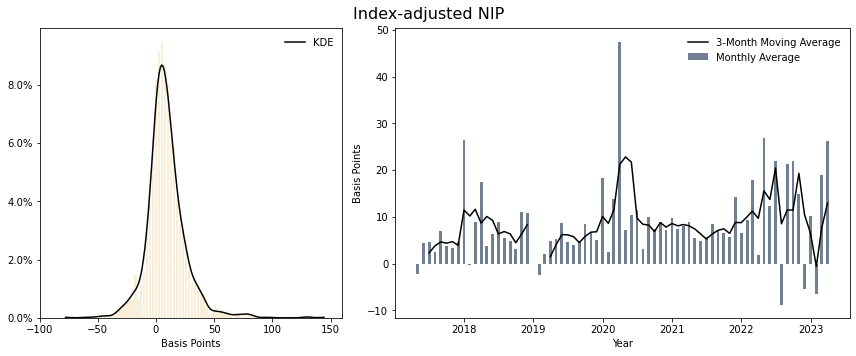

In [43]:
# Create a figure and two subplots, one on top of the other
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [4, 6]})

# Set the patch linewidth to 0 to remove any patch boundaries
plt.rcParams['patch.linewidth'] = 0

# ----- First Plot (Histogram with KDE) -----
# Plot the histogram with KDE (Kernel Density Estimate)
sns.histplot(data=issues_nip_average, x="NIP", kde=True, color='wheat', alpha=0.5, stat='percent', ax=ax1, shrink=0.8)

# Format the y-axis as percentages
ax1.yaxis.set_major_formatter(mtick.PercentFormatter())

# Set the color of the KDE curve to black
ax1.lines[0].set_color('black')

# Remove the x and y axis labels for the first plot
ax1.set_xlabel('')
ax1.set_ylabel('')

# Set the x-axis limits for the first plot
ax1.set_xlim(-100, 160)

# Set the x-axis label for the first plot
ax1.set_xlabel('Basis Points')

# Add a legend for the top plot (KDE curve)
ax1.legend(['KDE'], loc='upper right', framealpha=0)

# ----- Second Plot (Monthly Average and 3-Month Moving Average NIP) -----
# Calculate the monthly average of NIP and the 3-month moving average
monthly_avg = issues_nip_characteristics['NIP'].resample('M').mean()
moving_avg = monthly_avg.rolling(window=3).mean()

# Plot the monthly average NIP as bars with light blue color
ax2.bar(monthly_avg.index, monthly_avg, label='Monthly Average', color='slategray', width=15)

# Plot the 3-month moving average NIP as a line plot in black
ax2.plot(moving_avg.index, moving_avg, label='3-Month Moving Average', color='black')

# Set the x and y axis labels for the second plot
ax2.set_xlabel('Year')
ax2.set_ylabel('Basis Points')

# Add a legend for the bottom plot (monthly average and moving average)
ax2.legend(loc='upper right', framealpha=0)

# Adjust spacing between the two subplots to prevent overlap
plt.tight_layout()

# Add extra space between the title and subplots
plt.subplots_adjust(top=0.92)

# Add the title for the entire figure
plt.suptitle('Index-adjusted NIP', fontsize=16)

# Show the combined plot
# plt.savefig('nip_distribution_index.png', facecolor='w', dpi=300, bbox_inches='tight')
plt.show()

In [44]:
# Now, apply the describe() function to the 'NIP' column
nip_descriptive_stats = issues_nip_average['NIP'].describe()

# Calculate the percentage of negative values
negative_percentage = (issues_nip_average['NIP'] < 0).mean() * 100

# Calculate the average of negative values
average_negative = issues_nip_average.loc[issues_nip_average['NIP'] < 0, 'NIP'].mean()

# Calculate the percentage of positive values
positive_percentage = (issues_nip_average['NIP'] >= 0).mean() * 100

# Calculate the average of positive values
average_positive = issues_nip_average.loc[issues_nip_average['NIP'] >= 0, 'NIP'].mean()

print(nip_descriptive_stats)
print(negative_percentage)
print(average_negative)
print(positive_percentage)
print(average_positive)

count    1829.000000
mean        8.754425
std        16.951438
min       -77.680856
25%         0.085222
50%         6.913026
75%        15.825571
max       144.213285
Name: NIP, dtype: float64
24.822307271733187
-9.02221754319342
75.1776927282668
14.623949241436746
